# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.all)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 10138 substitutions for model Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.all)


  0% (    1 of 10138) |                   | Elapsed Time: 0:00:03 ETA:  11:00:51

  0% (   77 of 10138) |                    | Elapsed Time: 0:00:04 ETA:  0:02:17

  1% (  127 of 10138) |                    | Elapsed Time: 0:00:05 ETA:  0:01:57

  2% (  212 of 10138) |                    | Elapsed Time: 0:00:06 ETA:  0:01:55

  2% (  254 of 10138) |                    | Elapsed Time: 0:00:06 ETA:  0:01:50

  3% (  381 of 10138) |                    | Elapsed Time: 0:00:08 ETA:  0:01:41

  5% (  507 of 10138) |#                   | Elapsed Time: 0:00:09 ETA:  0:01:35

  5% (  600 of 10138) |#                   | Elapsed Time: 0:00:10 ETA:  0:01:35

  6% (  634 of 10138) |#                   | Elapsed Time: 0:00:10 ETA:  0:01:29

  7% (  728 of 10138) |#                   | Elapsed Time: 0:00:11 ETA:  0:01:30

  7% (  761 of 10138) |#                   | Elapsed Time: 0:00:11 ETA:  0:01:28

  8% (  861 of 10138) |#                   | Elapsed Time: 0:00:12 ETA:  0:01:28

  8% (  888 of 10138) |#                   | Elapsed Time: 0:00:13 ETA:  0:01:29

  9% (  986 of 10138) |#                   | Elapsed Time: 0:00:14 ETA:  0:01:29

 10% ( 1014 of 10138) |##                  | Elapsed Time: 0:00:14 ETA:  0:01:30

 10% ( 1112 of 10138) |##                  | Elapsed Time: 0:00:15 ETA:  0:01:30

 11% ( 1141 of 10138) |##                  | Elapsed Time: 0:00:15 ETA:  0:01:29

 12% ( 1234 of 10138) |##                  | Elapsed Time: 0:00:16 ETA:  0:01:29

 12% ( 1268 of 10138) |##                  | Elapsed Time: 0:00:17 ETA:  0:01:35

 13% ( 1361 of 10138) |##                  | Elapsed Time: 0:00:18 ETA:  0:01:33

 13% ( 1394 of 10138) |##                  | Elapsed Time: 0:00:18 ETA:  0:01:35

 14% ( 1485 of 10138) |##                  | Elapsed Time: 0:00:19 ETA:  0:01:34

 15% ( 1521 of 10138) |###                 | Elapsed Time: 0:00:20 ETA:  0:01:34

 15% ( 1621 of 10138) |###                 | Elapsed Time: 0:00:21 ETA:  0:01:32

 16% ( 1648 of 10138) |###                 | Elapsed Time: 0:00:21 ETA:  0:01:32

 17% ( 1775 of 10138) |###                 | Elapsed Time: 0:00:22 ETA:  0:01:27

 18% ( 1869 of 10138) |###                 | Elapsed Time: 0:00:23 ETA:  0:01:19

 18% ( 1901 of 10138) |###                 | Elapsed Time: 0:00:23 ETA:  0:01:18

 20% ( 2028 of 10138) |####                | Elapsed Time: 0:00:25 ETA:  0:01:13

 20% ( 2117 of 10138) |####                | Elapsed Time: 0:00:26 ETA:  0:01:14

 21% ( 2155 of 10138) |####                | Elapsed Time: 0:00:26 ETA:  0:01:16

 22% ( 2240 of 10138) |####                | Elapsed Time: 0:00:27 ETA:  0:01:18

 22% ( 2282 of 10138) |####                | Elapsed Time: 0:00:28 ETA:  0:01:22

 23% ( 2408 of 10138) |####                | Elapsed Time: 0:00:29 ETA:  0:01:18

 25% ( 2535 of 10138) |#####               | Elapsed Time: 0:00:30 ETA:  0:01:16

 26% ( 2641 of 10138) |#####               | Elapsed Time: 0:00:31 ETA:  0:01:13

 26% ( 2662 of 10138) |#####               | Elapsed Time: 0:00:31 ETA:  0:01:11

 27% ( 2751 of 10138) |#####               | Elapsed Time: 0:00:32 ETA:  0:01:10

 27% ( 2788 of 10138) |#####               | Elapsed Time: 0:00:33 ETA:  0:01:14

 28% ( 2893 of 10138) |#####               | Elapsed Time: 0:00:34 ETA:  0:01:10

 28% ( 2915 of 10138) |#####               | Elapsed Time: 0:00:34 ETA:  0:01:11

 29% ( 3020 of 10138) |#####               | Elapsed Time: 0:00:35 ETA:  0:01:09

 30% ( 3042 of 10138) |######              | Elapsed Time: 0:00:36 ETA:  0:01:13

 30% ( 3128 of 10138) |######              | Elapsed Time: 0:00:37 ETA:  0:01:14

 31% ( 3169 of 10138) |######              | Elapsed Time: 0:00:37 ETA:  0:01:15

 32% ( 3295 of 10138) |######              | Elapsed Time: 0:00:38 ETA:  0:01:10

 33% ( 3422 of 10138) |######              | Elapsed Time: 0:00:39 ETA:  0:01:00

 34% ( 3531 of 10138) |######              | Elapsed Time: 0:00:40 ETA:  0:00:58

 35% ( 3549 of 10138) |#######             | Elapsed Time: 0:00:41 ETA:  0:01:00

 36% ( 3658 of 10138) |#######             | Elapsed Time: 0:00:42 ETA:  0:00:56

 36% ( 3676 of 10138) |#######             | Elapsed Time: 0:00:42 ETA:  0:00:54

 37% ( 3778 of 10138) |#######             | Elapsed Time: 0:00:43 ETA:  0:00:53

 37% ( 3802 of 10138) |#######             | Elapsed Time: 0:00:43 ETA:  0:00:54

 38% ( 3907 of 10138) |#######             | Elapsed Time: 0:00:44 ETA:  0:00:53

 38% ( 3929 of 10138) |#######             | Elapsed Time: 0:00:44 ETA:  0:00:54

 39% ( 4028 of 10138) |#######             | Elapsed Time: 0:00:45 ETA:  0:00:54

 40% ( 4056 of 10138) |########            | Elapsed Time: 0:00:46 ETA:  0:00:55

 41% ( 4182 of 10138) |########            | Elapsed Time: 0:00:47 ETA:  0:00:52

 42% ( 4282 of 10138) |########            | Elapsed Time: 0:00:48 ETA:  0:00:51

 42% ( 4309 of 10138) |########            | Elapsed Time: 0:00:48 ETA:  0:00:50

 43% ( 4436 of 10138) |########            | Elapsed Time: 0:00:49 ETA:  0:00:46

 44% ( 4539 of 10138) |########            | Elapsed Time: 0:00:50 ETA:  0:00:45

 45% ( 4563 of 10138) |#########           | Elapsed Time: 0:00:50 ETA:  0:00:44

 45% ( 4663 of 10138) |#########           | Elapsed Time: 0:00:51 ETA:  0:00:44

 46% ( 4689 of 10138) |#########           | Elapsed Time: 0:00:52 ETA:  0:00:45

 47% ( 4789 of 10138) |#########           | Elapsed Time: 0:00:53 ETA:  0:00:44

 47% ( 4816 of 10138) |#########           | Elapsed Time: 0:00:53 ETA:  0:00:44

 48% ( 4917 of 10138) |#########           | Elapsed Time: 0:00:54 ETA:  0:00:44

 48% ( 4943 of 10138) |#########           | Elapsed Time: 0:00:54 ETA:  0:00:47

 49% ( 5041 of 10138) |#########           | Elapsed Time: 0:00:55 ETA:  0:00:46

 50% ( 5069 of 10138) |##########          | Elapsed Time: 0:00:55 ETA:  0:00:46

 50% ( 5117 of 10138) |##########          | Elapsed Time: 0:00:56 ETA:  0:00:55

 51% ( 5196 of 10138) |##########          | Elapsed Time: 0:00:57 ETA:  0:00:53

 52% ( 5295 of 10138) |##########          | Elapsed Time: 0:00:58 ETA:  0:00:51

 52% ( 5323 of 10138) |##########          | Elapsed Time: 0:00:58 ETA:  0:00:52

 53% ( 5425 of 10138) |##########          | Elapsed Time: 0:00:59 ETA:  0:00:49

 53% ( 5450 of 10138) |##########          | Elapsed Time: 0:01:00 ETA:  0:00:50

 54% ( 5552 of 10138) |##########          | Elapsed Time: 0:01:01 ETA:  0:00:46

 55% ( 5576 of 10138) |###########         | Elapsed Time: 0:01:01 ETA:  0:00:47

 55% ( 5674 of 10138) |###########         | Elapsed Time: 0:01:02 ETA:  0:00:46

 56% ( 5703 of 10138) |###########         | Elapsed Time: 0:01:02 ETA:  0:00:37

 57% ( 5806 of 10138) |###########         | Elapsed Time: 0:01:03 ETA:  0:00:37

 57% ( 5830 of 10138) |###########         | Elapsed Time: 0:01:04 ETA:  0:00:37

 58% ( 5957 of 10138) |###########         | Elapsed Time: 0:01:05 ETA:  0:00:35

 59% ( 6053 of 10138) |###########         | Elapsed Time: 0:01:06 ETA:  0:00:35

 60% ( 6083 of 10138) |############        | Elapsed Time: 0:01:06 ETA:  0:00:36

 61% ( 6210 of 10138) |############        | Elapsed Time: 0:01:07 ETA:  0:00:32

 62% ( 6312 of 10138) |############        | Elapsed Time: 0:01:08 ETA:  0:00:30

 62% ( 6337 of 10138) |############        | Elapsed Time: 0:01:09 ETA:  0:00:31

 63% ( 6440 of 10138) |############        | Elapsed Time: 0:01:10 ETA:  0:00:30

 63% ( 6463 of 10138) |############        | Elapsed Time: 0:01:10 ETA:  0:00:31

 64% ( 6564 of 10138) |############        | Elapsed Time: 0:01:11 ETA:  0:00:30

 65% ( 6590 of 10138) |#############       | Elapsed Time: 0:01:11 ETA:  0:00:29

 66% ( 6693 of 10138) |#############       | Elapsed Time: 0:01:12 ETA:  0:00:27

 66% ( 6717 of 10138) |#############       | Elapsed Time: 0:01:12 ETA:  0:00:28

 67% ( 6844 of 10138) |#############       | Elapsed Time: 0:01:13 ETA:  0:00:25

 68% ( 6948 of 10138) |#############       | Elapsed Time: 0:01:14 ETA:  0:00:23

 68% ( 6970 of 10138) |#############       | Elapsed Time: 0:01:15 ETA:  0:00:23

 69% ( 7059 of 10138) |#############       | Elapsed Time: 0:01:16 ETA:  0:00:24

 70% ( 7097 of 10138) |##############      | Elapsed Time: 0:01:16 ETA:  0:00:25

 70% ( 7187 of 10138) |##############      | Elapsed Time: 0:01:17 ETA:  0:00:25

 71% ( 7224 of 10138) |##############      | Elapsed Time: 0:01:18 ETA:  0:00:25

 72% ( 7323 of 10138) |##############      | Elapsed Time: 0:01:19 ETA:  0:00:25

 72% ( 7351 of 10138) |##############      | Elapsed Time: 0:01:19 ETA:  0:00:26

 73% ( 7439 of 10138) |##############      | Elapsed Time: 0:01:20 ETA:  0:00:27

 73% ( 7477 of 10138) |##############      | Elapsed Time: 0:01:20 ETA:  0:00:28

 74% ( 7573 of 10138) |##############      | Elapsed Time: 0:01:21 ETA:  0:00:27

 75% ( 7604 of 10138) |###############     | Elapsed Time: 0:01:22 ETA:  0:00:26

 75% ( 7692 of 10138) |###############     | Elapsed Time: 0:01:23 ETA:  0:00:25

 76% ( 7731 of 10138) |###############     | Elapsed Time: 0:01:23 ETA:  0:00:23

 77% ( 7857 of 10138) |###############     | Elapsed Time: 0:01:24 ETA:  0:00:21

 78% ( 7915 of 10138) |###############     | Elapsed Time: 0:01:25 ETA:  0:00:28

 78% ( 7984 of 10138) |###############     | Elapsed Time: 0:01:26 ETA:  0:00:26

 80% ( 8111 of 10138) |################    | Elapsed Time: 0:01:27 ETA:  0:00:23

 81% ( 8214 of 10138) |################    | Elapsed Time: 0:01:28 ETA:  0:00:20

 81% ( 8238 of 10138) |################    | Elapsed Time: 0:01:28 ETA:  0:00:18

 82% ( 8364 of 10138) |################    | Elapsed Time: 0:01:29 ETA:  0:00:17

 83% ( 8454 of 10138) |################    | Elapsed Time: 0:01:31 ETA:  0:00:17

 83% ( 8491 of 10138) |################    | Elapsed Time: 0:01:31 ETA:  0:00:08

 85% ( 8618 of 10138) |#################   | Elapsed Time: 0:01:32 ETA:  0:00:06

 85% ( 8713 of 10138) |#################   | Elapsed Time: 0:01:33 ETA:  0:00:06

 86% ( 8745 of 10138) |#################   | Elapsed Time: 0:01:33 ETA:  0:00:06

 87% ( 8847 of 10138) |#################   | Elapsed Time: 0:01:34 ETA:  0:00:05

 87% ( 8871 of 10138) |#################   | Elapsed Time: 0:01:35 ETA:  0:00:06

 88% ( 8973 of 10138) |#################   | Elapsed Time: 0:01:36 ETA:  0:00:05

 88% ( 8998 of 10138) |#################   | Elapsed Time: 0:01:36 ETA:  0:00:02

 89% ( 9102 of 10138) |#################   | Elapsed Time: 0:01:37 ETA:  0:00:01

 90% ( 9125 of 10138) |##################  | Elapsed Time: 0:01:37 ETA:  0:00:01

 91% ( 9251 of 10138) |##################  | Elapsed Time: 0:01:38 ETA:  0:00:00

 92% ( 9343 of 10138) |##################  | Elapsed Time: 0:01:39 ETA:  0:00:00

 92% ( 9378 of 10138) |##################  | Elapsed Time: 0:01:40 ETA:  0:00:00

 93% ( 9478 of 10138) |##################  | Elapsed Time: 0:01:41 ETA:  0:00:00

 93% ( 9505 of 10138) |##################  | Elapsed Time: 0:01:41 ETA:  0:00:00

 94% ( 9588 of 10138) |##################  | Elapsed Time: 0:01:42 ETA:  0:00:02

 95% ( 9632 of 10138) |################### | Elapsed Time: 0:01:42 ETA:  0:00:03

 95% ( 9727 of 10138) |################### | Elapsed Time: 0:01:43 ETA:  0:00:02

 96% ( 9758 of 10138) |################### | Elapsed Time: 0:01:44 ETA:  0:00:04

 97% ( 9860 of 10138) |################### | Elapsed Time: 0:01:45 ETA:  0:00:02

 97% ( 9885 of 10138) |################### | Elapsed Time: 0:01:45 ETA:  0:00:01

 98% (10012 of 10138) |################### | Elapsed Time: 0:01:46 ETA:  0:00:00

 99% (10102 of 10138) |################### | Elapsed Time: 0:01:47 ETA:  0:00:00

100% (10138 of 10138) |####################| Elapsed Time: 0:01:47 Time: 0:01:47


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

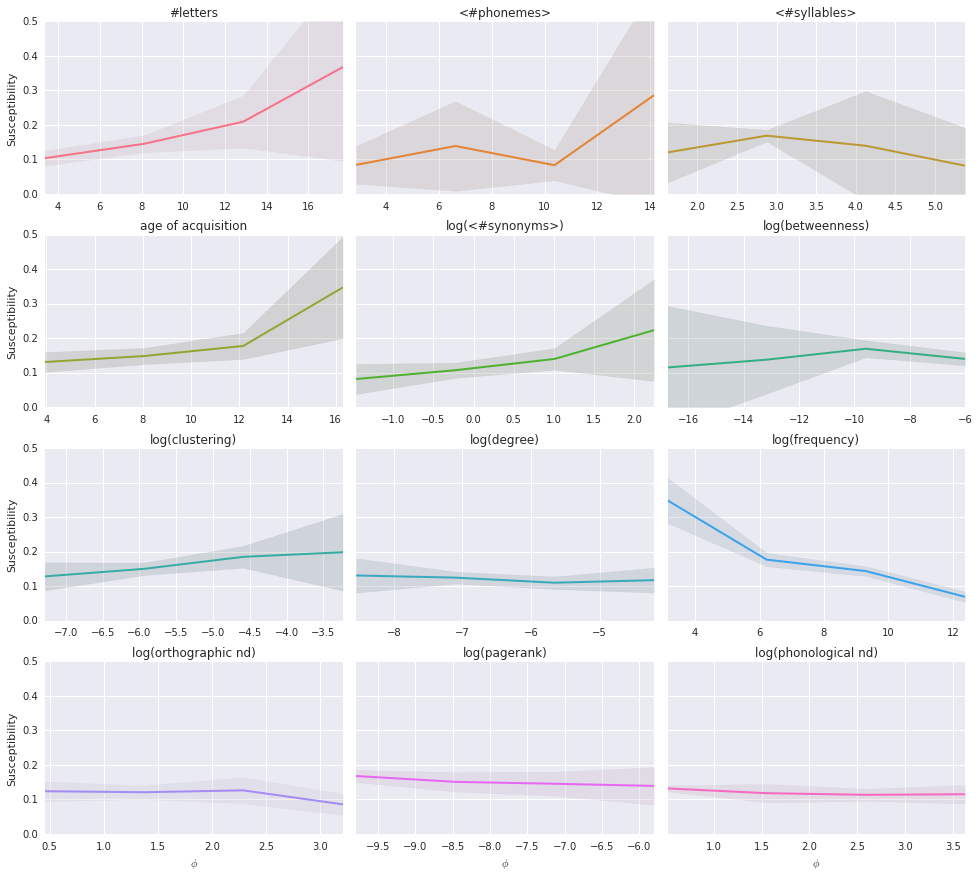

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

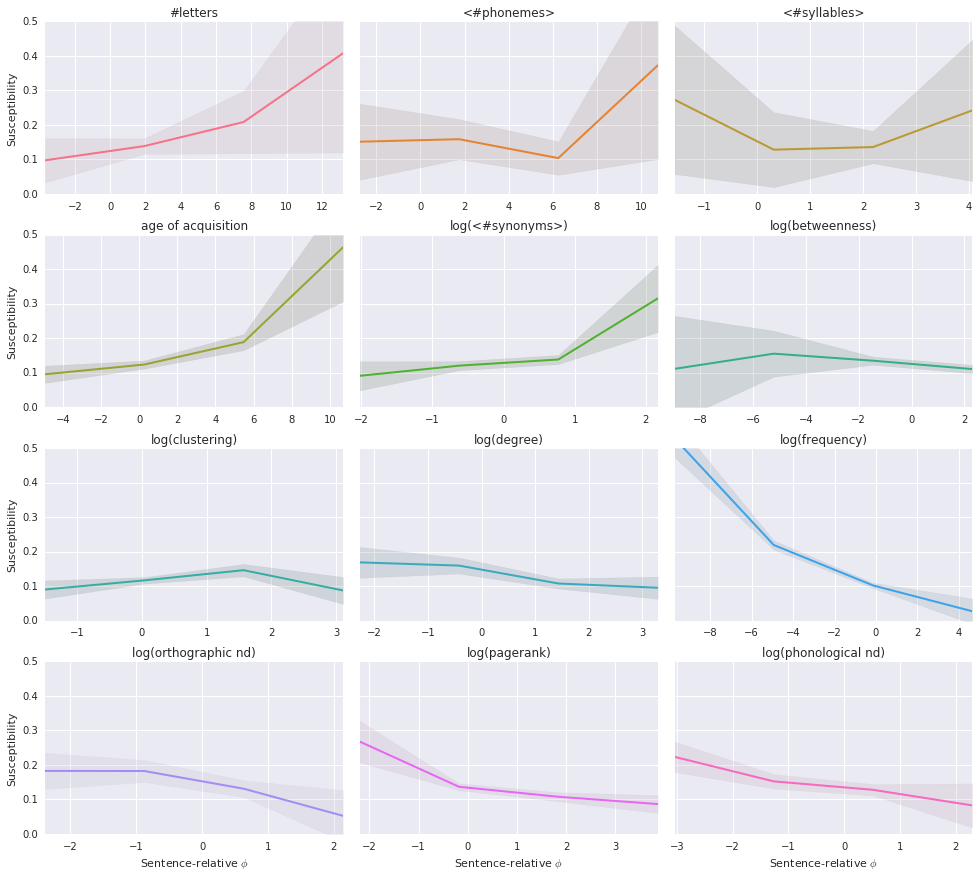

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

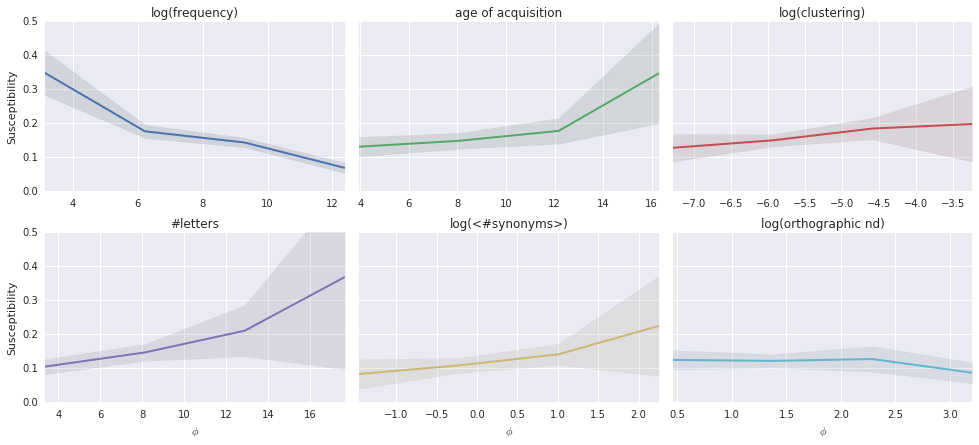

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

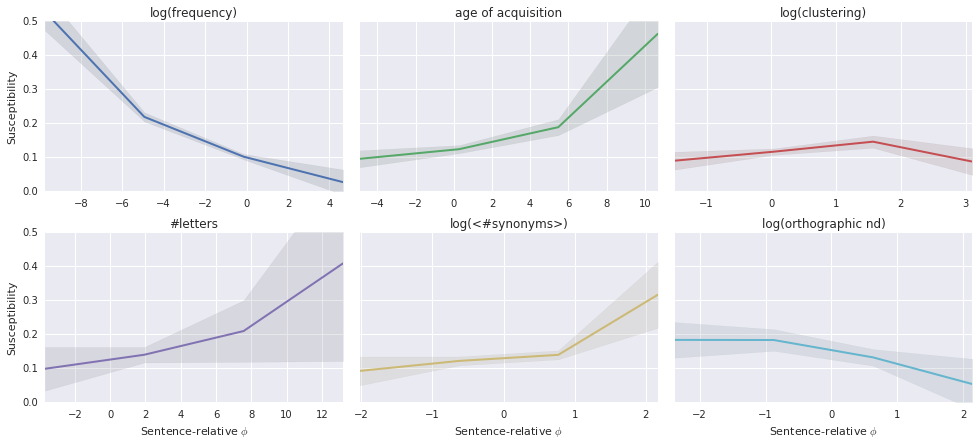

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

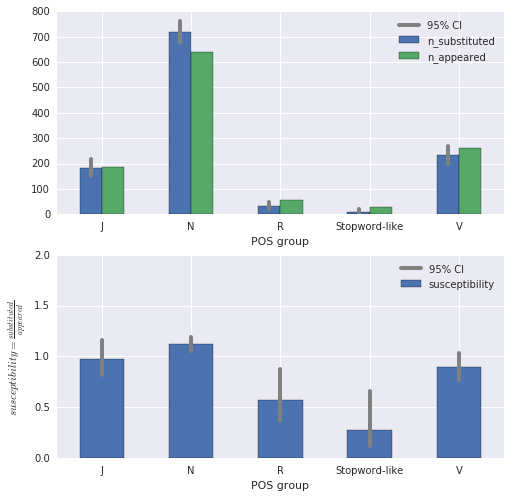

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

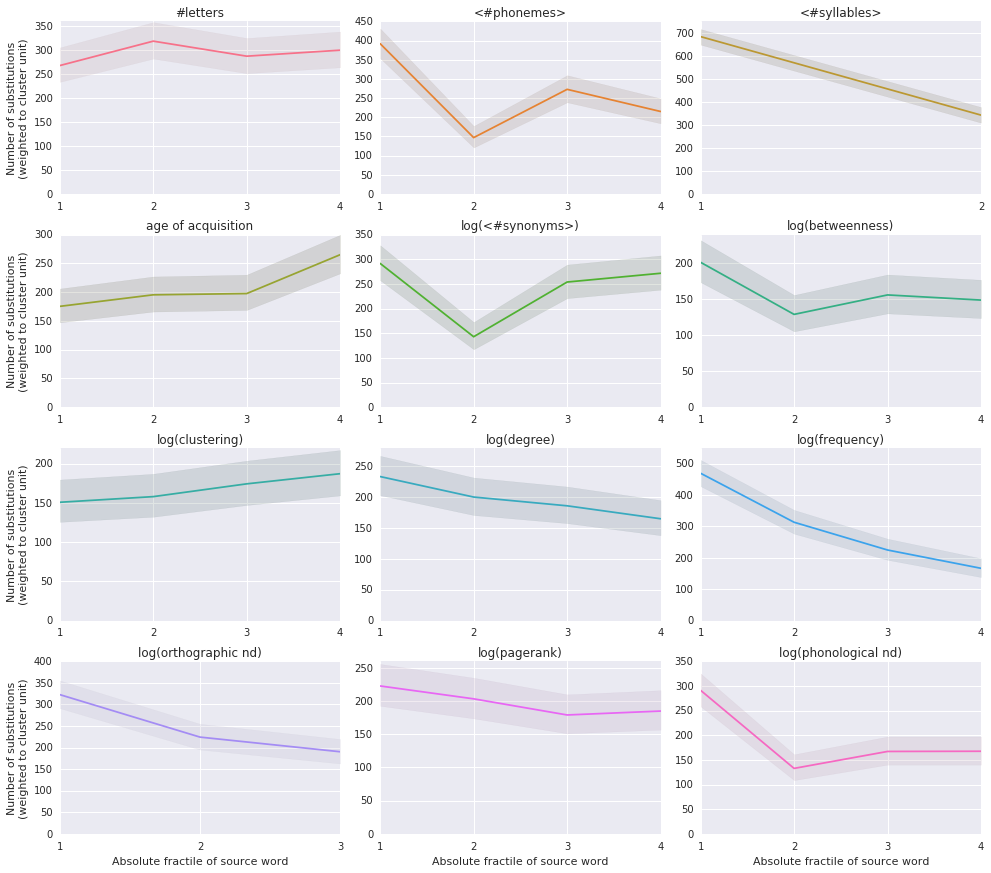

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

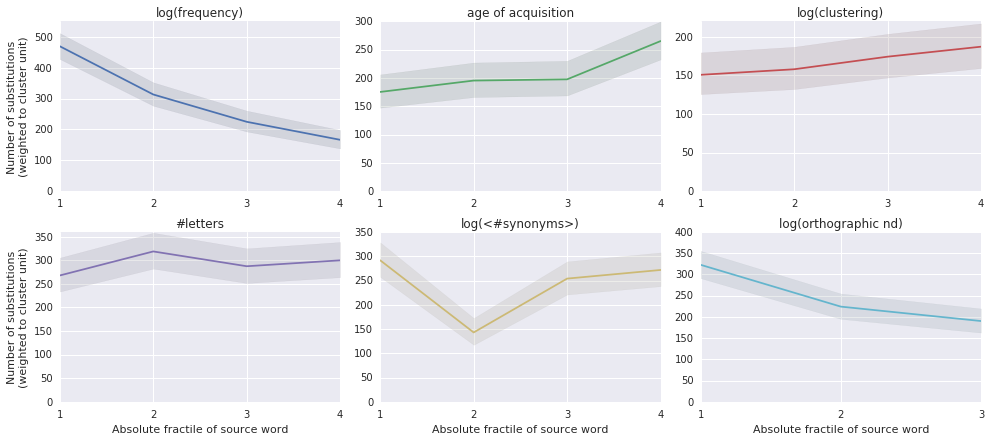

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (   98 of 10138) |                    | Elapsed Time: 0:00:01 ETA:  0:01:42

  1% (  127 of 10138) |                    | Elapsed Time: 0:00:01 ETA:  0:01:09

  2% (  221 of 10138) |                    | Elapsed Time: 0:00:02 ETA:  0:01:37

  2% (  254 of 10138) |                    | Elapsed Time: 0:00:02 ETA:  0:01:35

  3% (  359 of 10138) |                    | Elapsed Time: 0:00:03 ETA:  0:01:34

  3% (  381 of 10138) |                    | Elapsed Time: 0:00:03 ETA:  0:01:33

  4% (  481 of 10138) |                    | Elapsed Time: 0:00:04 ETA:  0:01:34

  5% (  507 of 10138) |#                   | Elapsed Time: 0:00:05 ETA:  0:01:34

  5% (  605 of 10138) |#                   | Elapsed Time: 0:00:06 ETA:  0:01:34

  6% (  634 of 10138) |#                   | Elapsed Time: 0:00:06 ETA:  0:01:34

  7% (  722 of 10138) |#                   | Elapsed Time: 0:00:07 ETA:  0:01:37

  7% (  761 of 10138) |#                   | Elapsed Time: 0:00:07 ETA:  0:01:36

  8% (  888 of 10138) |#                   | Elapsed Time: 0:00:08 ETA:  0:01:35

  9% (  976 of 10138) |#                   | Elapsed Time: 0:00:09 ETA:  0:01:36

 10% ( 1014 of 10138) |##                  | Elapsed Time: 0:00:10 ETA:  0:01:35

 10% ( 1107 of 10138) |##                  | Elapsed Time: 0:00:11 ETA:  0:01:35

 11% ( 1141 of 10138) |##                  | Elapsed Time: 0:00:11 ETA:  0:01:37

 12% ( 1229 of 10138) |##                  | Elapsed Time: 0:00:12 ETA:  0:01:37

 12% ( 1268 of 10138) |##                  | Elapsed Time: 0:00:13 ETA:  0:01:36

 13% ( 1357 of 10138) |##                  | Elapsed Time: 0:00:14 ETA:  0:01:35

 13% ( 1394 of 10138) |##                  | Elapsed Time: 0:00:14 ETA:  0:01:37

 14% ( 1489 of 10138) |##                  | Elapsed Time: 0:00:15 ETA:  0:01:36

 15% ( 1521 of 10138) |###                 | Elapsed Time: 0:00:16 ETA:  0:01:36

 15% ( 1622 of 10138) |###                 | Elapsed Time: 0:00:17 ETA:  0:01:34

 16% ( 1648 of 10138) |###                 | Elapsed Time: 0:00:17 ETA:  0:01:34

 17% ( 1746 of 10138) |###                 | Elapsed Time: 0:00:18 ETA:  0:01:30

 17% ( 1775 of 10138) |###                 | Elapsed Time: 0:00:18 ETA:  0:01:29

 18% ( 1870 of 10138) |###                 | Elapsed Time: 0:00:19 ETA:  0:01:27

 18% ( 1901 of 10138) |###                 | Elapsed Time: 0:00:19 ETA:  0:01:27

 19% ( 1993 of 10138) |###                 | Elapsed Time: 0:00:21 ETA:  0:01:27

 20% ( 2028 of 10138) |####                | Elapsed Time: 0:00:21 ETA:  0:01:27

 20% ( 2108 of 10138) |####                | Elapsed Time: 0:00:22 ETA:  0:01:28

 21% ( 2155 of 10138) |####                | Elapsed Time: 0:00:23 ETA:  0:01:31

 22% ( 2247 of 10138) |####                | Elapsed Time: 0:00:24 ETA:  0:01:30

 22% ( 2282 of 10138) |####                | Elapsed Time: 0:00:24 ETA:  0:01:31

 23% ( 2367 of 10138) |####                | Elapsed Time: 0:00:25 ETA:  0:01:30

 23% ( 2408 of 10138) |####                | Elapsed Time: 0:00:25 ETA:  0:01:32

 24% ( 2491 of 10138) |####                | Elapsed Time: 0:00:26 ETA:  0:01:32

 25% ( 2535 of 10138) |#####               | Elapsed Time: 0:00:27 ETA:  0:01:30

 26% ( 2662 of 10138) |#####               | Elapsed Time: 0:00:28 ETA:  0:01:22

 27% ( 2788 of 10138) |#####               | Elapsed Time: 0:00:29 ETA:  0:01:14

 28% ( 2884 of 10138) |#####               | Elapsed Time: 0:00:30 ETA:  0:01:13

 28% ( 2915 of 10138) |#####               | Elapsed Time: 0:00:30 ETA:  0:01:12

 29% ( 3007 of 10138) |#####               | Elapsed Time: 0:00:31 ETA:  0:01:10

 30% ( 3042 of 10138) |######              | Elapsed Time: 0:00:32 ETA:  0:01:06

 31% ( 3169 of 10138) |######              | Elapsed Time: 0:00:33 ETA:  0:01:04

 32% ( 3273 of 10138) |######              | Elapsed Time: 0:00:34 ETA:  0:01:02

 32% ( 3295 of 10138) |######              | Elapsed Time: 0:00:34 ETA:  0:01:05

 33% ( 3397 of 10138) |######              | Elapsed Time: 0:00:35 ETA:  0:01:04

 33% ( 3422 of 10138) |######              | Elapsed Time: 0:00:35 ETA:  0:01:02

 34% ( 3516 of 10138) |######              | Elapsed Time: 0:00:36 ETA:  0:01:01

 35% ( 3549 of 10138) |#######             | Elapsed Time: 0:00:37 ETA:  0:01:00

 35% ( 3644 of 10138) |#######             | Elapsed Time: 0:00:38 ETA:  0:01:01

 36% ( 3676 of 10138) |#######             | Elapsed Time: 0:00:38 ETA:  0:01:05

 37% ( 3776 of 10138) |#######             | Elapsed Time: 0:00:39 ETA:  0:01:04

 37% ( 3802 of 10138) |#######             | Elapsed Time: 0:00:39 ETA:  0:01:06

 38% ( 3870 of 10138) |#######             | Elapsed Time: 0:00:41 ETA:  0:01:17

 38% ( 3929 of 10138) |#######             | Elapsed Time: 0:00:41 ETA:  0:01:19

 39% ( 4030 of 10138) |#######             | Elapsed Time: 0:00:42 ETA:  0:01:16

 40% ( 4056 of 10138) |########            | Elapsed Time: 0:00:43 ETA:  0:01:16

 40% ( 4147 of 10138) |########            | Elapsed Time: 0:00:44 ETA:  0:01:15

 41% ( 4182 of 10138) |########            | Elapsed Time: 0:00:44 ETA:  0:01:16

 42% ( 4272 of 10138) |########            | Elapsed Time: 0:00:45 ETA:  0:01:14

 42% ( 4309 of 10138) |########            | Elapsed Time: 0:00:45 ETA:  0:01:16

 43% ( 4410 of 10138) |########            | Elapsed Time: 0:00:46 ETA:  0:01:11

 43% ( 4436 of 10138) |########            | Elapsed Time: 0:00:47 ETA:  0:00:58

 44% ( 4524 of 10138) |########            | Elapsed Time: 0:00:48 ETA:  0:00:58

 45% ( 4563 of 10138) |#########           | Elapsed Time: 0:00:48 ETA:  0:00:59

 45% ( 4662 of 10138) |#########           | Elapsed Time: 0:00:49 ETA:  0:00:57

 46% ( 4689 of 10138) |#########           | Elapsed Time: 0:00:49 ETA:  0:00:55

 47% ( 4789 of 10138) |#########           | Elapsed Time: 0:00:50 ETA:  0:00:53

 47% ( 4816 of 10138) |#########           | Elapsed Time: 0:00:51 ETA:  0:00:51

 48% ( 4910 of 10138) |#########           | Elapsed Time: 0:00:52 ETA:  0:00:52

 48% ( 4943 of 10138) |#########           | Elapsed Time: 0:00:52 ETA:  0:00:53

 49% ( 5042 of 10138) |#########           | Elapsed Time: 0:00:53 ETA:  0:00:51

 50% ( 5069 of 10138) |##########          | Elapsed Time: 0:00:53 ETA:  0:00:49

 50% ( 5157 of 10138) |##########          | Elapsed Time: 0:00:54 ETA:  0:00:50

 51% ( 5196 of 10138) |##########          | Elapsed Time: 0:00:55 ETA:  0:00:50

 52% ( 5295 of 10138) |##########          | Elapsed Time: 0:00:56 ETA:  0:00:49

 52% ( 5323 of 10138) |##########          | Elapsed Time: 0:00:56 ETA:  0:00:51

 53% ( 5408 of 10138) |##########          | Elapsed Time: 0:00:57 ETA:  0:00:52

 53% ( 5450 of 10138) |##########          | Elapsed Time: 0:00:58 ETA:  0:00:51

 55% ( 5576 of 10138) |###########         | Elapsed Time: 0:00:59 ETA:  0:00:46

 56% ( 5703 of 10138) |###########         | Elapsed Time: 0:01:00 ETA:  0:00:40

 57% ( 5830 of 10138) |###########         | Elapsed Time: 0:01:01 ETA:  0:00:34

 58% ( 5925 of 10138) |###########         | Elapsed Time: 0:01:02 ETA:  0:00:33

 58% ( 5957 of 10138) |###########         | Elapsed Time: 0:01:02 ETA:  0:00:30

 60% ( 6083 of 10138) |############        | Elapsed Time: 0:01:03 ETA:  0:00:27

 60% ( 6171 of 10138) |############        | Elapsed Time: 0:01:04 ETA:  0:00:30

 61% ( 6210 of 10138) |############        | Elapsed Time: 0:01:05 ETA:  0:00:31

 62% ( 6305 of 10138) |############        | Elapsed Time: 0:01:06 ETA:  0:00:31

 62% ( 6337 of 10138) |############        | Elapsed Time: 0:01:06 ETA:  0:00:35

 63% ( 6436 of 10138) |############        | Elapsed Time: 0:01:07 ETA:  0:00:34

 63% ( 6463 of 10138) |############        | Elapsed Time: 0:01:07 ETA:  0:00:33

 64% ( 6570 of 10138) |############        | Elapsed Time: 0:01:08 ETA:  0:00:31

 65% ( 6590 of 10138) |#############       | Elapsed Time: 0:01:08 ETA:  0:00:34

 66% ( 6717 of 10138) |#############       | Elapsed Time: 0:01:09 ETA:  0:00:27

 67% ( 6844 of 10138) |#############       | Elapsed Time: 0:01:10 ETA:  0:00:21

 68% ( 6970 of 10138) |#############       | Elapsed Time: 0:01:11 ETA:  0:00:15

 69% ( 7077 of 10138) |#############       | Elapsed Time: 0:01:12 ETA:  0:00:15

 70% ( 7097 of 10138) |##############      | Elapsed Time: 0:01:13 ETA:  0:00:14

 70% ( 7192 of 10138) |##############      | Elapsed Time: 0:01:14 ETA:  0:00:15

 71% ( 7224 of 10138) |##############      | Elapsed Time: 0:01:14 ETA:  0:00:13

 72% ( 7319 of 10138) |##############      | Elapsed Time: 0:01:15 ETA:  0:00:14

 72% ( 7351 of 10138) |##############      | Elapsed Time: 0:01:15 ETA:  0:00:13

 73% ( 7477 of 10138) |##############      | Elapsed Time: 0:01:16 ETA:  0:00:15

 74% ( 7581 of 10138) |##############      | Elapsed Time: 0:01:17 ETA:  0:00:18

 75% ( 7604 of 10138) |###############     | Elapsed Time: 0:01:17 ETA:  0:00:20

 75% ( 7691 of 10138) |###############     | Elapsed Time: 0:01:18 ETA:  0:00:21

 76% ( 7731 of 10138) |###############     | Elapsed Time: 0:01:19 ETA:  0:00:18

 77% ( 7857 of 10138) |###############     | Elapsed Time: 0:01:20 ETA:  0:00:13

 78% ( 7984 of 10138) |###############     | Elapsed Time: 0:01:21 ETA:  0:00:09

 80% ( 8111 of 10138) |################    | Elapsed Time: 0:01:22 ETA:  0:00:08

 81% ( 8238 of 10138) |################    | Elapsed Time: 0:01:23 ETA:  0:00:05

 82% ( 8338 of 10138) |################    | Elapsed Time: 0:01:24 ETA:  0:00:02

 82% ( 8364 of 10138) |################    | Elapsed Time: 0:01:24 ETA:  0:00:02

 83% ( 8491 of 10138) |################    | Elapsed Time: 0:01:25 ETA:  0:00:05

 85% ( 8618 of 10138) |#################   | Elapsed Time: 0:01:26 ETA:  0:00:04

 86% ( 8745 of 10138) |#################   | Elapsed Time: 0:01:28 ETA:  0:00:03

 87% ( 8844 of 10138) |#################   | Elapsed Time: 0:01:29 ETA:  0:00:03

 87% ( 8871 of 10138) |#################   | Elapsed Time: 0:01:29 ETA:  0:00:02

 88% ( 8998 of 10138) |#################   | Elapsed Time: 0:01:30 ETA:  0:00:02

 89% ( 9103 of 10138) |#################   | Elapsed Time: 0:01:31 ETA:  0:00:02

 90% ( 9125 of 10138) |##################  | Elapsed Time: 0:01:31 ETA:  0:00:03

 91% ( 9251 of 10138) |##################  | Elapsed Time: 0:01:32 ETA:  0:00:03

 92% ( 9378 of 10138) |##################  | Elapsed Time: 0:01:33 ETA:  0:00:00

 93% ( 9505 of 10138) |##################  | Elapsed Time: 0:01:35 ETA:  0:00:00

 95% ( 9632 of 10138) |################### | Elapsed Time: 0:01:36 ETA:  0:00:00

 95% ( 9732 of 10138) |################### | Elapsed Time: 0:01:37 ETA:  0:00:00

 96% ( 9758 of 10138) |################### | Elapsed Time: 0:01:37 ETA:  0:00:00

 97% ( 9861 of 10138) |################### | Elapsed Time: 0:01:38 ETA:  0:00:00

 97% ( 9885 of 10138) |################### | Elapsed Time: 0:01:38 ETA:  0:00:00

 98% (10012 of 10138) |################### | Elapsed Time: 0:01:39 ETA:  0:00:00

100% (10138 of 10138) |####################| Elapsed Time: 0:01:40 Time: 0:01:40


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

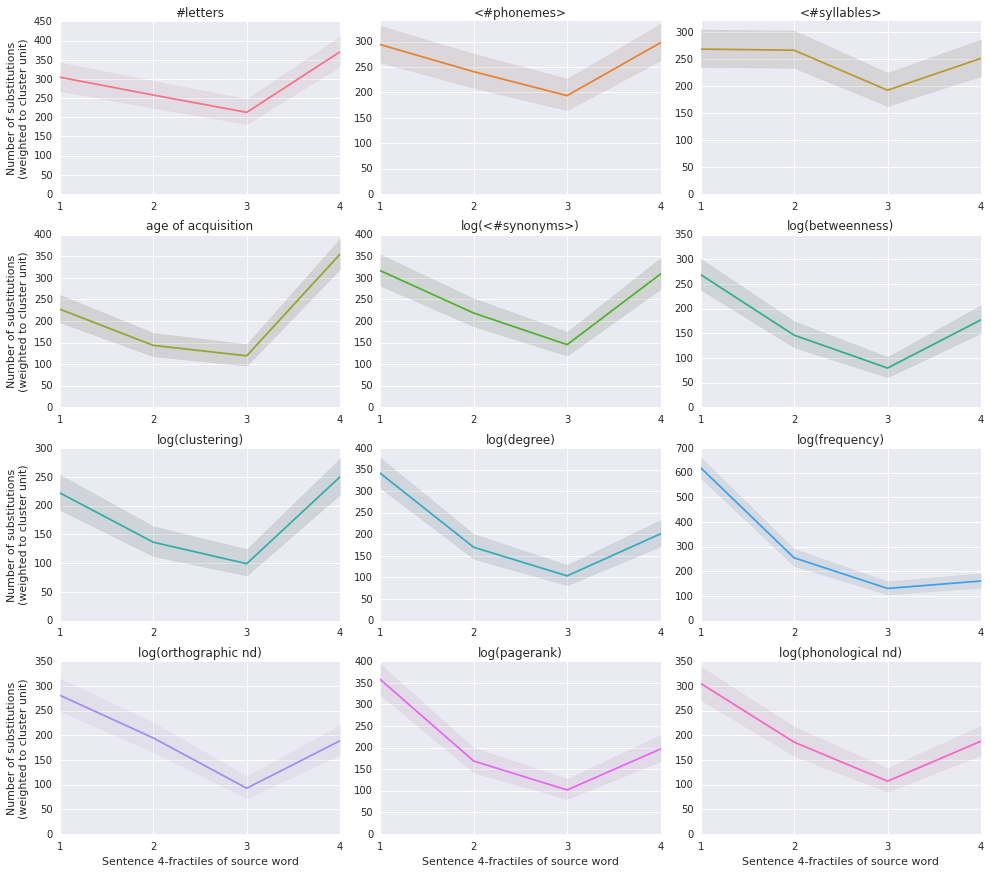

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

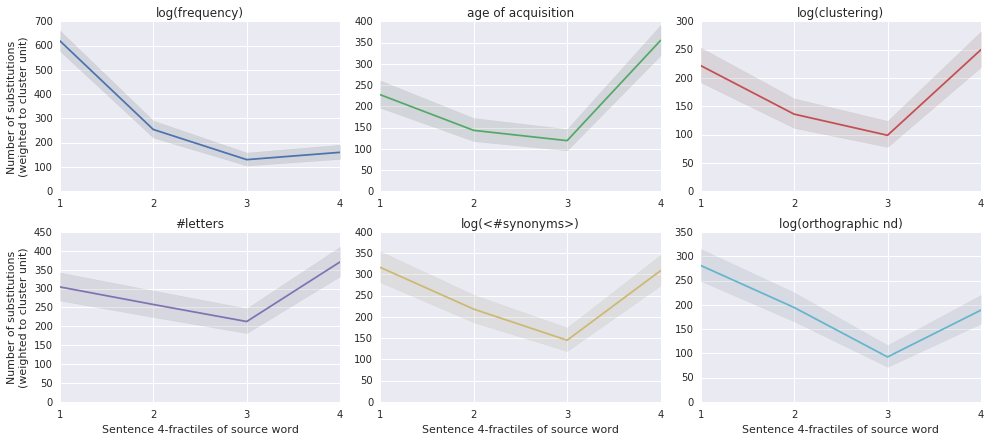

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)